
# Multi-Task Attention Network
## COMS 4995 Sec: 006 Final Project
Daming Xing (dx2222) 

12/09/2022

Video Presentation: https://youtu.be/qwgj_WAEB1s

## Introduction

Convolutional Neural Networks (CNNs), while successful in a range of computer vision tasks, are typically designed for single-task learning. When used in real-world applications, however, where multiple tasks usually need to be worked on simultaneously, building a set of independent networks may not be the most desirable or efficient. 

To enable such simultaneous performance of tasks and inturn allowing for increased memory efficiency, inference speed, and ability to share informative features between related tasks, Multi-Task Learning (MTL) [4,5,6], was proposed.

Despite its advantages, however, MTL does have its share of challenges in comparison to standard single-task learning:

1. **Network Architecture**: Both task-shared and task-specific elements should be expressed in a MTL architecture. This ensures that over or under-fitting is prevented by giving the network the chance to learn both features specific to each job and a generalizable representation. 

2. **Loss Function**: MTL's loss function need to be able to assign all tasks equal importance, regardless of the difficulty of the task. 

To address both challenges, Johns & Davidson (2019) [1] proposed a novel architecture called the Multi-Task Attention Network (MTAN) that allows a shared network to learn a global feature pool created across all tasks.


Inspired by John & Davidson (2019), this project aims at deriving a single network that can be used for various different computer vision tasks, specifically *senmantic segmentation and depth estimation*.

## Related Work

With parallels to transfer learning and continual learning, the term Multi-Task Learning (MTL) has been widely used in machine learning. Multi-task learning has been applied to computer vision in order to learn related tasks such picture categorization across different domains, pose estimation, action identification, dense prediction of depth, surface normals, and semantic classes. Most multi-task learning network architectures for com- puter vision are designed based on existing CNN architectures.

One typical feed-forward network, with cross-stitch units to allow features to be exchanged between tasks, is included in Cross-Stitch Networks, for instance. The ResNet101 that is a self-supervised technique learns a regularized collection of features from various levels of a single shared network. In order to process images at various resolutions, UberNet suggests an image pyramid technique, in which extra task-specific layers are built on top of the shared VGG-Net for each resolution. To transmit knowledge between tasks, the Progressive Networks uses a series of gradually trained networks.

## Methods

The goal of this project is that I want to derive one single network that can be used to solve multiple tasks. These different tasks can be object detection, object classification and object segmentation, and so on. The constraint in this project is that I cannot have multiple networks for these different tasks.  The advantage of having only one network over multiple networks is that I don't have to train multiple networks individually for the different tasks. It results in saving some time in training, as well as in inferencing.

The two tasks in this project are:
- Semantic segmentation
- Depth estimation

The workflow to do this, is that given an input image, the first step is to calculate the shared features. Then I have task-specific modules that use those shared features to solve their given task. For N number of tasks, I am  going to have N specific attention modules. These attention modules take some data from the shared features and augment it in such a way, that is useful for their particular task. The word attention over here refers to the attention that each module gives to its particular task.

The word attention over here refers to the attention that each module gives to its particular task.

![Images](report_imgs/share_features.jpg)

For the MTAN technique, we can use any convolutional network to calculate the shared features. For this particular project, I used SegNet for the shared features. SegNet is a fully convolution network (FCN) that is used to solve the image segmentation task. 

The first step I did is to downsample the image and derive the features from that image. Once we downsample the image and reach the bottleneck, we upsample the image to the same dimension as the given input image. And with the help of the features derived in the downsampling task, the output is a segmentation mask. The downsampling part of the network is also called the encoder and the upsampling part of the network is also called the decoder.

MTAN is a single network, which consists of attention modules. Each task-specific network is made up of a collection of attention modules that connect to the common network, whereas the shared network can be created dependent on the individual task. To identify task-specific features, each attention module applies a soft attention mask to a specific layer of the shared network. As a result, attention masks can be thought of as feature selectors from the shared network that are automatically learnt in an end-to-end fashion, whereas the shared network learns a small global feature pool across all jobs.

![Images](report_imgs/segnet.jpg)

The diagram below illustrates the encoder portion of SegNet and provides a thorough representation of the network based on VGG16. Thus, the SegNet decoder half is symmetric to VGG16. As demonstrated, each attention module learns a soft attention mask that depends on the shared network properties at the appropriate layer. In order to maximize the generalization of the shared features across different tasks, as well as the task-specific performance due to the attention masks, the features in the shared network and the soft attention masks can be learnt together.

Here is the architecture is developed using SegNet as a base network with attention models. Convolution blocks comprise of convolution layers. followed by some pooling layers. 

![Images](report_imgs/architectures.jpg)

MTAN visualization based on VGG16 displaying SegNet's encoder half (with the decoder half being symmetrical to the encoder). The attention modules for tasks one (green) and two (blue) are distinct from one another and connect to the shared network (grey). The bottom section of the picture, which is extended, shows both the encoder and decoder versions of the middle attention module, which has its structure exposed for visualization. The design of each attention module is the same, but each module's weights are independently learnt.

### Task Specific Attention Module

#### Upsampling filter
For the upsampling attention module, the input is from the previous attention module, and another input is derived from the first layer of the convolution block. These two matrices then are merged. The convolution operation on them is computed twice, and then the elementwise multiplication of the output is calculated and the input of one of the filters of these convolution blocks. this element wise multiplication is once again sent through a convolution block and the output is returned to the next attention module.

![Images](report_imgs/upsampling.jpg)

#### Downsampling filter
For the downsampling module, the input from the previous attention module is sent through convolution block which is then merged with the input of the first layer of the convolution block. This merged filter is then passed twice through convolution blocks. Then an elementwide multiplication is calculated for this output and the input that is taken from one of the layers of convolution block. Then, this final output is sent to the next attention module. 

![Images](report_imgs/downsampling.jpg)



### Model Objective (loss function)

For the model objective, I used mean Intersection over Union (mIoU) and prediction accuracy for the depth estimation.

$$IoU = \frac{TF}{TP+FN+FP}$$

where true-positives are those pixels that belong to the class and are correctly predicted as the class, false-negatives are those pixels that belong to the class but are incorrectly predicted as a different class and false-positives are those pixels that belong to a different class but are predicted as the class. 

Recent approaches have attempted to overcome this problem since, for the majority of multi-task learning networks, training many tasks is challenging without achieving the ideal balance between those tasks. The adjustment of the weights of these losses is very important for the network to actually converge and learn the different tasks. Dynamic Weight Averaging is a technique that is used to determine these weights based on the rate of change of the gradient loss. Dynamic Weight Average (DWA) is very straightforward yet efficient adaptive weighting technique to test the suggested solution using a variety of weighting systems. By taking into account the rate of change of loss for each task, learns to average task weighting over time. GradNorm, however, needs access to the internal gradients of the network, whereas the DWA solution simply needs the numerical task loss. As a result, its implementation is much easier.

$$ Loss_{total} = \lambda_1 * loss_1 + \lambda_2 * loss_2  $$

The $\lambda_1$, $\lambda_2$ and $\lambda_3$ are parameters in the networks as well.

## Dataset

The City Scape dataset consists of different street view images, that is, images taken from a car that is being driven on the road. This data set is particularly used for depth estimation and semantic segmentation. Together with ground-truth inverse depth labels, the dataset includes 19 classes for pixel-wise semantic segmentation. The 19 classes' labels and the seven coarser categories' labels are the same as those in the original CityScapes dataset.

![Images](report_imgs/sample_dataset.jpg)
![Images](report_imgs/dataset_classes.jpg)



## Results

### Segmentation - Side by Side
![Images](report_imgs/seg_demo_1.png)
![Images](report_imgs/seg_demo_2.png)
![Images](report_imgs/seg_demo_3.png)
![Images](report_imgs/seg_demo_4.png)
![Images](report_imgs/seg_demo_5.png)
![Images](report_imgs/seg_demo_6.png)
![Images](report_imgs/seg_demo_7.png)
![Images](report_imgs/seg_demo_8.png)

### Depth Estimation - Side by Side
![Images](report_imgs/depth_demo_1.png)
![Images](report_imgs/depth_demo_2.png)
![Images](report_imgs/depth_demo_3.png)
![Images](report_imgs/depth_demo_4.png)
![Images](report_imgs/depth_demo_5.png)
![Images](report_imgs/depth_demo_6.png)
![Images](report_imgs/depth_demo_7.png)
![Images](report_imgs/depth_demo_8.png)

### Segmentation - Overlay
![Images](report_imgs/seg_overlay_1.png)
![Images](report_imgs/seg_overlay_2.png)
![Images](report_imgs/seg_overlay_3.png)
![Images](report_imgs/seg_overlay_4.png)
![Images](report_imgs/seg_overlay_5.png)

### Depth Estimation - Overlay (not as clear as side by side)
![Images](report_imgs/depth_overlay_1.png)
![Images](report_imgs/depth_overlay_2.png)
![Images](report_imgs/depth_overlay_3.png)
![Images](report_imgs/depth_overlay_4.png)
![Images](report_imgs/depth_overlay_5.png)

### Learning Curve
I trained the network from scratch to 100 epochs. It took more than 7 hours to complete the training process. 

![Images](report_imgs/learning_rate.jpg)

I also split the training data into "training" and "validation". Although in the graph, it seems that the network is overfitted within 10 epochs, I still think more training will result better segmentations. 

## Conclusion
A global feature pool and task-specific attention modules make up the network architecture, which enables automatic learning of both task-shared and task-specific characteristics in an end-to-end way. The technique performs well in experiments utilizing the CityScapes datasets with several tasks, including semantic segmentation and depth estimation, and it also demonstrates robustness to the specific task weighting schemes employed in the loss function using DWA.

### Future Work
Although I mentioned a single Multi-task Learning network would be faster during both train inference than multiple single-task networks, I did not have the time to confirm if that is still the case. Therefore, I will test it out in the future by using multiple single networks as a baseline to compare with a single multi-tasks network in training and inference speed.

On the other hand, in the paper, the authors also implemented different flavors of MTAN. In this project, I only implemented the most basic MTAN. In the future, I want to test out different versions of MTAN networks, such as Multi-Task, Split (Wide, Deep), Multi-Task, Dense and Multi-Task, Cross-Stitch. 

Also, by looking at the result, I think training the network with more epochs will result in a better model. However, the Google Cloud Platform (GCP) with class voucher was not too friendly with PyTorch, so I had to implement this project on AWS EC2 GPU with my own out-of-pocket money. Unfortunately, I did not train this network for more than 100 epochs.

## Citation
[1] S. Liu, E. Johns and A. J. Davison, "End-To-End Multi-Task Learning With Attention," 2019 IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR), 2019, pp. 1871-1880, doi: 10.1109/CVPR.2019.00197.

[2] Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun. Deep residual learning for image recognition. In Proceed- ings of the IEEE conference on computer vision and pattern recognition, pages 770–778, 2016.

[3] Justin Johnson, Alexandre Alahi, and Li Fei-Fei. Perceptual losses for real-time style transfer and super-resolution. In European Conference on Computer Vision, pages 694–711. Springer, 2016.

[4] IshanMisra, AbhinavShrivastava, AbhinavGupta, and Martial Hebert. Cross-stitch networks for multi-task learning. In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition, pages 3994–4003, 2016.

[5] Carl Doersch and Andrew Zisserman. Multi-task self-supervised visual learning. In The IEEE International Con- ference on Computer Vision (ICCV), Oct 2017.

## Code

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
import torch.utils.data.sampler as sampler

import os
import fnmatch
import numpy as np
import random
import matplotlib.pyplot as plt

### Dataset Loader

In [2]:
class CityScapes(Dataset):
    def __init__(self, root, train=True):
        self.train = train
        self.root = os.path.expanduser(root)

        # read the data file
        if train:
            self.data_path = root + '/train'
        else:
            self.data_path = root + '/val'

        # calculate data length
        self.data_len = len(fnmatch.filter(os.listdir(self.data_path + '/image'), '*.npy'))

    def __getitem__(self, index):
        # load data from the pre-processed npy files
        image = torch.from_numpy(np.moveaxis(np.load(self.data_path + '/image/{:d}.npy'.format(index)), -1, 0))
        semantic = torch.from_numpy(np.load(self.data_path + '/label/{:d}.npy'.format(index)))
        depth = torch.from_numpy(np.moveaxis(np.load(self.data_path + '/depth/{:d}.npy'.format(index)), -1, 0))
        
        return image.float(), semantic.float(), depth.float()

    def __len__(self):
        return self.data_len

### Utility Functions

Define Task Metrics, Loss Functions and Model Trainer

In [3]:
def model_fit(x_pred, x_output, task_type):
    device = x_pred.device

    # binary mark to mask out undefined pixel space
    binary_mask = (torch.sum(x_output, dim=1) != 0).float().unsqueeze(1).to(device)

    if task_type == 'semantic':
        # semantic loss: depth-wise cross entropy
        loss = F.nll_loss(x_pred, x_output, ignore_index=-1)

    if task_type == 'depth':
        # depth loss: l1 norm
        loss = torch.sum(
            torch.abs(x_pred - x_output) * binary_mask) / torch.nonzero(binary_mask, as_tuple=False).size(0)

    return loss

In [4]:
# mIoU and Acc. formula: accumulate every pixel and average across all pixels in all images
class ConfMatrix(object):
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.mat = None

    def update(self, pred, target):
        n = self.num_classes
        if self.mat is None:
            self.mat = torch.zeros((n, n), dtype=torch.int64, device=pred.device)
        with torch.no_grad():
            k = (target >= 0) & (target < n)
            inds = n * target[k].to(torch.int64) + pred[k]
            self.mat += torch.bincount(inds, minlength=n ** 2).reshape(n, n)

    def get_metrics(self):
        h = self.mat.float()
        acc = torch.diag(h).sum() / h.sum()
        iu = torch.diag(h) / (h.sum(1) + h.sum(0) - torch.diag(h))
        return torch.mean(iu), acc
    

In [3]:
def depth_error(x_pred, x_output):
    device = x_pred.device
    binary_mask = (torch.sum(x_output, dim=1) != 0).unsqueeze(1).to(device)
    x_pred_true = x_pred.masked_select(binary_mask)
    x_output_true = x_output.masked_select(binary_mask)
    abs_err = torch.abs(x_pred_true - x_output_true)
    rel_err = torch.abs(x_pred_true - x_output_true) / x_output_true
    return (torch.sum(abs_err) / torch.nonzero(binary_mask, as_tuple=False).size(0)).item(), \
           (torch.sum(rel_err) / torch.nonzero(binary_mask, as_tuple=False).size(0)).item()

_loss = []
def multi_task_trainer(train_loader, test_loader, multi_task_model, device, optimizer, scheduler, config, total_epoch=200):
    train_batch = len(train_loader)
    test_batch = len(test_loader)
    
    T = config['temp']
    avg_cost = np.zeros([total_epoch, 12], dtype=np.float32)
    lambda_weight = np.ones([2, total_epoch])
    
    for index in range(total_epoch):
        cost = np.zeros(12, dtype=np.float32)

        # apply Dynamic Weight Average
        if config['weight'] == 'dwa':
            if index == 0 or index == 1:
                lambda_weight[:, index] = 1.0
            else:
                w_1 = avg_cost[index - 1, 0] / avg_cost[index - 2, 0]
                w_2 = avg_cost[index - 1, 3] / avg_cost[index - 2, 3]
                lambda_weight[0, index] = 2 * np.exp(w_1 / T) / (np.exp(w_1 / T) + np.exp(w_2 / T))
                lambda_weight[1, index] = 2 * np.exp(w_2 / T) / (np.exp(w_1 / T) + np.exp(w_2 / T))

        # iteration for all batches
        multi_task_model.train()
        train_dataset = iter(train_loader)
        conf_mat = ConfMatrix(multi_task_model.class_nb)
        for k in range(train_batch):
            train_data, train_label, train_depth = next(train_dataset)
            train_data, train_label = train_data.to(device), train_label.long().to(device)
            train_depth = train_depth.to(device)

            train_pred, logsigma = multi_task_model(train_data)

            optimizer.zero_grad()
            train_loss = [model_fit(train_pred[0], train_label, 'semantic'),
                          model_fit(train_pred[1], train_depth, 'depth')]

            if config['weight'] == 'equal' or config['weight'] == 'dwa':
                loss = sum([lambda_weight[i, index] * train_loss[i] for i in range(2)])
            else:
                loss = sum(1 / (2 * torch.exp(logsigma[i])) * train_loss[i] + logsigma[i] / 2 for i in range(2))

            loss.backward()
            optimizer.step()

            # accumulate label prediction for every pixel in training images
            conf_mat.update(train_pred[0].argmax(1).flatten(), train_label.flatten())

            cost[0] = train_loss[0].item()
            cost[3] = train_loss[1].item()
            cost[4], cost[5] = depth_error(train_pred[1], train_depth)
            avg_cost[index, :6] += cost[:6] / train_batch

        # compute mIoU and acc
        mIoU, acc = conf_mat.get_metrics()
        tmp = (mIoU.cpu(), mIoU.cpu())
        avg_cost[index, 1:3] = tmp

        # evaluating test data
        multi_task_model.eval()
        conf_mat = ConfMatrix(multi_task_model.class_nb)
        with torch.no_grad():  # operations inside don't track history
            test_dataset = iter(test_loader)
            for k in range(test_batch):
                test_data, test_label, test_depth = next(test_dataset)
                test_data, test_label = test_data.to(device), test_label.long().to(device)
                test_depth = test_depth.to(device)

                test_pred, _ = multi_task_model(test_data)
                test_loss = [model_fit(test_pred[0], test_label, 'semantic'),
                             model_fit(test_pred[1], test_depth, 'depth')]

                conf_mat.update(test_pred[0].argmax(1).flatten(), test_label.flatten())

                cost[6] = test_loss[0].item()
                cost[9] = test_loss[1].item()
                cost[10], cost[11] = depth_error(test_pred[1], test_depth)
                avg_cost[index, 6:] += cost[6:] / test_batch

            # compute mIoU and acc
            mIoU, acc = conf_mat.get_metrics()
            tmp = (mIoU.cpu(), mIoU.cpu())            
            avg_cost[index, 7:9] = tmp

        scheduler.step()
        _loss.append(avg_cost[index, :])
        print('Epoch: {:04d} | TRAIN: {:.4f} {:.4f} | {:.4f} {:.4f} ||'
            'VALIDATION: {:.4f} {:.4f} | {:.4f} {:.4f} '
            .format(index, avg_cost[index, 0], avg_cost[index, 1],
                    avg_cost[index, 4], avg_cost[index, 5], avg_cost[index, 6], avg_cost[index, 7],
                    avg_cost[index, 10], avg_cost[index, 11]))

### Network
Followed the paper and define the network architecture

In [4]:
class SegNet(nn.Module):
    def __init__(self):
        super(SegNet, self).__init__()

        
        # initialise network parameters
        filter = [64, 128, 256, 512, 512]
        self.class_nb = 19

        # define encoder decoder layers
        self.encoder_block = nn.ModuleList([self.conv_layer([3, filter[0]])])
        self.decoder_block = nn.ModuleList([self.conv_layer([filter[0], filter[0]])])
        for i in range(4):
            self.encoder_block.append(self.conv_layer([filter[i], filter[i + 1]]))
            self.decoder_block.append(self.conv_layer([filter[i + 1], filter[i]]))

        # define convolution layer
        self.conv_block_enc = nn.ModuleList([self.conv_layer([filter[0], filter[0]])])
        self.conv_block_dec = nn.ModuleList([self.conv_layer([filter[0], filter[0]])])
        for i in range(4):
            if i == 0:
                self.conv_block_enc.append(self.conv_layer([filter[i + 1], filter[i + 1]]))
                self.conv_block_dec.append(self.conv_layer([filter[i], filter[i]]))
            else:
                self.conv_block_enc.append(nn.Sequential(self.conv_layer([filter[i + 1], filter[i + 1]]),
                                                         self.conv_layer([filter[i + 1], filter[i + 1]])))
                self.conv_block_dec.append(nn.Sequential(self.conv_layer([filter[i], filter[i]]),
                                                         self.conv_layer([filter[i], filter[i]])))

        # define task attention layers
        self.encoder_att = nn.ModuleList([nn.ModuleList([self.att_layer([filter[0], filter[0], filter[0]])])])
        self.decoder_att = nn.ModuleList([nn.ModuleList([self.att_layer([2 * filter[0], filter[0], filter[0]])])])
        self.encoder_block_att = nn.ModuleList([self.conv_layer([filter[0], filter[1]])])
        self.decoder_block_att = nn.ModuleList([self.conv_layer([filter[0], filter[0]])])

        for j in range(2):
            if j < 2:
                self.encoder_att.append(nn.ModuleList([self.att_layer([filter[0], filter[0], filter[0]])]))
                self.decoder_att.append(nn.ModuleList([self.att_layer([2 * filter[0], filter[0], filter[0]])]))
            for i in range(4):
                self.encoder_att[j].append(self.att_layer([2 * filter[i + 1], filter[i + 1], filter[i + 1]]))
                self.decoder_att[j].append(self.att_layer([filter[i + 1] + filter[i], filter[i], filter[i]]))

        for i in range(4):
            if i < 3:
                self.encoder_block_att.append(self.conv_layer([filter[i + 1], filter[i + 2]]))
                self.decoder_block_att.append(self.conv_layer([filter[i + 1], filter[i]]))
            else:
                self.encoder_block_att.append(self.conv_layer([filter[i + 1], filter[i + 1]]))
                self.decoder_block_att.append(self.conv_layer([filter[i + 1], filter[i + 1]]))

        self.pred_task1 = self.conv_layer([filter[0], self.class_nb], pred=True)
        self.pred_task2 = self.conv_layer([filter[0], 1], pred=True)

        # define pooling and unpooling functions
        self.down_sampling = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.up_sampling = nn.MaxUnpool2d(kernel_size=2, stride=2)

        self.logsigma = nn.Parameter(torch.FloatTensor([-0.5, -0.5, -0.5]))

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def conv_layer(self, channel, pred=False):
        if not pred:
            conv_block = nn.Sequential(
                nn.Conv2d(in_channels=channel[0], out_channels=channel[1], kernel_size=3, padding=1),
                nn.BatchNorm2d(num_features=channel[1]),
                nn.ReLU(inplace=True),
            )
        else:
            conv_block = nn.Sequential(
                nn.Conv2d(in_channels=channel[0], out_channels=channel[0], kernel_size=3, padding=1),
                nn.Conv2d(in_channels=channel[0], out_channels=channel[1], kernel_size=1, padding=0),
            )
        return conv_block

    def att_layer(self, channel):
        att_block = nn.Sequential(
            nn.Conv2d(in_channels=channel[0], out_channels=channel[1], kernel_size=1, padding=0),
            nn.BatchNorm2d(channel[1]),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=channel[1], out_channels=channel[2], kernel_size=1, padding=0),
            nn.BatchNorm2d(channel[2]),
            nn.Sigmoid(),
        )
        return att_block

    def forward(self, x):
        g_encoder, g_decoder, g_maxpool, g_upsampl, indices = ([0] * 5 for _ in range(5))
        for i in range(5):
            g_encoder[i], g_decoder[-i - 1] = ([0] * 2 for _ in range(2))

        # define attention list for tasks
        atten_encoder, atten_decoder = ([0] * 3 for _ in range(2))
        for i in range(2):
            atten_encoder[i], atten_decoder[i] = ([0] * 5 for _ in range(2))
        for i in range(2):
            for j in range(5):
                atten_encoder[i][j], atten_decoder[i][j] = ([0] * 3 for _ in range(2))

        # define global shared network
        for i in range(5):
            if i == 0:
                g_encoder[i][0] = self.encoder_block[i](x)
                g_encoder[i][1] = self.conv_block_enc[i](g_encoder[i][0])
                g_maxpool[i], indices[i] = self.down_sampling(g_encoder[i][1])
            else:
                g_encoder[i][0] = self.encoder_block[i](g_maxpool[i - 1])
                g_encoder[i][1] = self.conv_block_enc[i](g_encoder[i][0])
                g_maxpool[i], indices[i] = self.down_sampling(g_encoder[i][1])

        for i in range(5):
            if i == 0:
                g_upsampl[i] = self.up_sampling(g_maxpool[-1], indices[-i - 1])
                g_decoder[i][0] = self.decoder_block[-i - 1](g_upsampl[i])
                g_decoder[i][1] = self.conv_block_dec[-i - 1](g_decoder[i][0])
            else:
                g_upsampl[i] = self.up_sampling(g_decoder[i - 1][-1], indices[-i - 1])
                g_decoder[i][0] = self.decoder_block[-i - 1](g_upsampl[i])
                g_decoder[i][1] = self.conv_block_dec[-i - 1](g_decoder[i][0])

        # define task dependent attention module
        for i in range(2):
            for j in range(5):
                if j == 0:
                    atten_encoder[i][j][0] = self.encoder_att[i][j](g_encoder[j][0])
                    atten_encoder[i][j][1] = (atten_encoder[i][j][0]) * g_encoder[j][1]
                    atten_encoder[i][j][2] = self.encoder_block_att[j](atten_encoder[i][j][1])
                    atten_encoder[i][j][2] = F.max_pool2d(atten_encoder[i][j][2], kernel_size=2, stride=2)
                else:
                    atten_encoder[i][j][0] = self.encoder_att[i][j](torch.cat((g_encoder[j][0], atten_encoder[i][j - 1][2]), dim=1))
                    atten_encoder[i][j][1] = (atten_encoder[i][j][0]) * g_encoder[j][1]
                    atten_encoder[i][j][2] = self.encoder_block_att[j](atten_encoder[i][j][1])
                    atten_encoder[i][j][2] = F.max_pool2d(atten_encoder[i][j][2], kernel_size=2, stride=2)

            for j in range(5):
                if j == 0:
                    atten_decoder[i][j][0] = F.interpolate(atten_encoder[i][-1][-1], scale_factor=2, mode='bilinear', align_corners=True)
                    atten_decoder[i][j][0] = self.decoder_block_att[-j - 1](atten_decoder[i][j][0])
                    atten_decoder[i][j][1] = self.decoder_att[i][-j - 1](torch.cat((g_upsampl[j], atten_decoder[i][j][0]), dim=1))
                    atten_decoder[i][j][2] = (atten_decoder[i][j][1]) * g_decoder[j][-1]
                else:
                    atten_decoder[i][j][0] = F.interpolate(atten_decoder[i][j - 1][2], scale_factor=2, mode='bilinear', align_corners=True)
                    atten_decoder[i][j][0] = self.decoder_block_att[-j - 1](atten_decoder[i][j][0])
                    atten_decoder[i][j][1] = self.decoder_att[i][-j - 1](torch.cat((g_upsampl[j], atten_decoder[i][j][0]), dim=1))
                    atten_decoder[i][j][2] = (atten_decoder[i][j][1]) * g_decoder[j][-1]

        # define task prediction layers
        t1_pred = F.log_softmax(self.pred_task1(atten_decoder[0][-1][-1]), dim=1)
        t2_pred = self.pred_task2(atten_decoder[1][-1][-1])

        return [t1_pred, t2_pred], self.logsigma

### Training

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
config = {
    'temp': 2.0,
    'weight': 'dwa'
}
device

device(type='cuda', index=0)

### Model, Optimizer and Scheduler

In [6]:
SegNet_MTAN = SegNet().to(device)
optimizer = optim.Adam(SegNet_MTAN.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

print('LOSS FORMAT: SEMANTIC_LOSS MEAN_IOU PIX_ACC | DEPTH_LOSS ABS_ERR REL_ERR <11.25 <22.5')

LOSS FORMAT: SEMANTIC_LOSS MEAN_IOU PIX_ACC | DEPTH_LOSS ABS_ERR REL_ERR <11.25 <22.5


### Dataset Loading

In [7]:
dataset_path = '.'
train_set = CityScapes(root=dataset_path, train=True)
test_set = CityScapes(root=dataset_path, train=False)

batch_size = 16
train_loader = torch.utils.data.DataLoader(
               dataset=train_set,
               batch_size=batch_size,
               shuffle=True)

test_loader = torch.utils.data.DataLoader(
              dataset=test_set,
              batch_size=batch_size,
              shuffle=False)

## Train

In [8]:
multi_task_trainer(train_loader,
                   test_loader,
                   SegNet_MTAN,
                   device,
                   optimizer,
                   scheduler,
                   config,
                   100)

Epoch: 0000 | TRAIN: 1.3019 0.1110 | 0.1000 264.8485 ||VALIDATION: 0.8140 0.1792 | 0.0389 115.6575 
Epoch: 0001 | TRAIN: 0.6849 0.2068 | 0.0329 78.9241 ||VALIDATION: 0.7282 0.2000 | 0.0302 74.1709 
Epoch: 0002 | TRAIN: 0.5887 0.2311 | 0.0270 63.5757 ||VALIDATION: 0.6361 0.2272 | 0.0262 75.9499 
Epoch: 0003 | TRAIN: 0.5354 0.2490 | 0.0255 57.3513 ||VALIDATION: 0.5901 0.2378 | 0.0250 60.7712 
Epoch: 0004 | TRAIN: 0.4891 0.2693 | 0.0238 53.3895 ||VALIDATION: 0.5579 0.2496 | 0.0227 62.1998 
Epoch: 0005 | TRAIN: 0.4616 0.2835 | 0.0223 53.5165 ||VALIDATION: 0.5616 0.2591 | 0.0224 65.7789 
Epoch: 0006 | TRAIN: 0.4371 0.2944 | 0.0218 51.2193 ||VALIDATION: 0.5208 0.2663 | 0.0253 63.9843 
Epoch: 0007 | TRAIN: 0.4126 0.3069 | 0.0224 50.9415 ||VALIDATION: 0.4800 0.2819 | 0.0218 53.6568 
Epoch: 0008 | TRAIN: 0.3911 0.3207 | 0.0201 48.2632 ||VALIDATION: 0.4732 0.2895 | 0.0225 50.5156 
Epoch: 0009 | TRAIN: 0.3737 0.3397 | 0.0194 48.0168 ||VALIDATION: 0.4761 0.3003 | 0.0229 51.3667 
Epoch: 0010 | TRAI

Epoch: 0084 | TRAIN: 0.0765 0.8352 | 0.0098 30.6686 ||VALIDATION: 0.5915 0.3732 | 0.0188 37.9473 
Epoch: 0085 | TRAIN: 0.0754 0.8371 | 0.0105 30.4827 ||VALIDATION: 0.5941 0.3723 | 0.0168 35.7745 
Epoch: 0086 | TRAIN: 0.0749 0.8376 | 0.0099 30.3093 ||VALIDATION: 0.5966 0.3734 | 0.0175 34.9044 
Epoch: 0087 | TRAIN: 0.0740 0.8394 | 0.0095 30.1162 ||VALIDATION: 0.6042 0.3766 | 0.0198 33.9777 
Epoch: 0088 | TRAIN: 0.0745 0.8384 | 0.0096 29.9573 ||VALIDATION: 0.6170 0.3673 | 0.0188 33.1941 
Epoch: 0089 | TRAIN: 0.0742 0.8383 | 0.0100 30.2804 ||VALIDATION: 0.6035 0.3763 | 0.0169 34.8666 
Epoch: 0090 | TRAIN: 0.0739 0.8390 | 0.0101 30.0585 ||VALIDATION: 0.6004 0.3722 | 0.0197 37.8226 
Epoch: 0091 | TRAIN: 0.0738 0.8392 | 0.0098 29.6652 ||VALIDATION: 0.6073 0.3696 | 0.0180 34.5080 
Epoch: 0092 | TRAIN: 0.0740 0.8387 | 0.0099 29.7259 ||VALIDATION: 0.6023 0.3734 | 0.0156 35.1581 
Epoch: 0093 | TRAIN: 0.0740 0.8383 | 0.0096 29.8060 ||VALIDATION: 0.5883 0.3769 | 0.0177 33.7239 
Epoch: 0094 | TRAIN:

In [ ]:
len(_loss)

In [30]:
len(_loss[:][0])

10

In [9]:
train_loss = [_loss[x][0] for x in range(len(_loss))]
val_loss = [_loss[x][6] for x in range(len(_loss))]

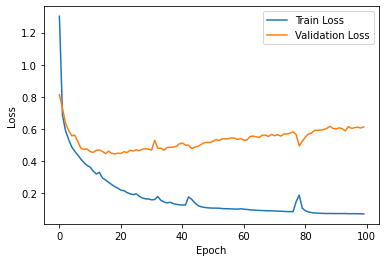

In [10]:
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

### Testing

In [11]:
VALID_DIR = 'val/'
n_files = 10
files = random.sample(os.listdir(VALID_DIR + 'image'), n_files)

In [12]:
segmentations = []
depths = []

for file in files:
    img = torch.from_numpy(np.expand_dims(np.moveaxis(np.load(VALID_DIR + 'image/' + file), -1, 0), axis = 0))
    img = img.to(device)
    prediction, _ = SegNet_MTAN(img.float())
    
    seg_prediction = np.moveaxis(prediction[0][0].cpu().detach().numpy(), 0, -1).argmax(2)
    depth_prediction = np.moveaxis(prediction[1][0].cpu().detach().numpy(), 0, -1)
    
    segmentations.append(seg_prediction)
    depths.append(depth_prediction)

### Segmentation Labels

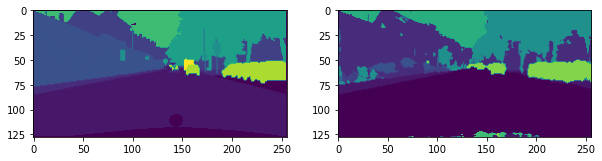

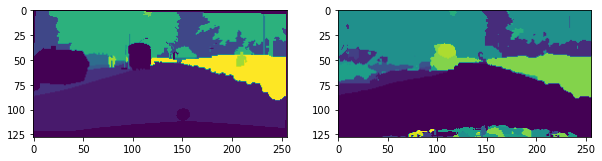

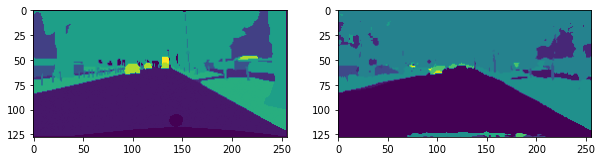

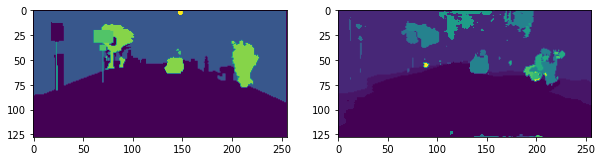

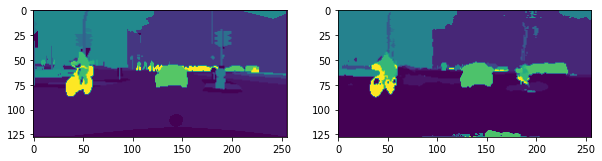

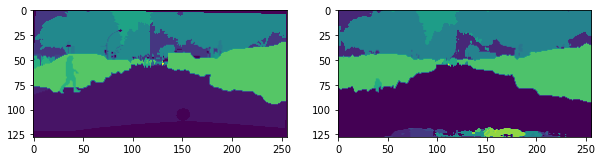

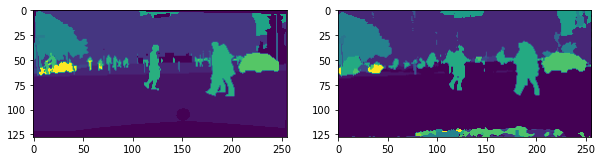

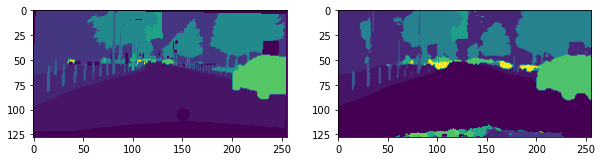

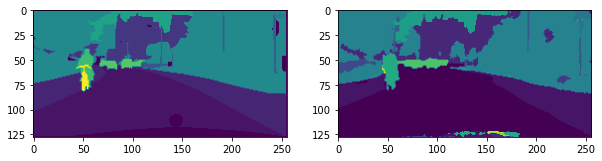

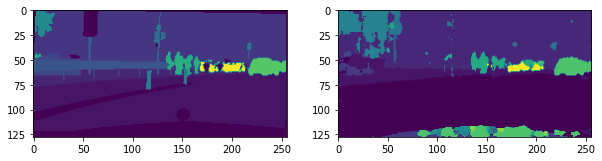

In [33]:
i = 1
for file, seg_pred in zip(files, segmentations):
    seg_label = np.load(VALID_DIR + 'label/' + file)
    
    plt.figure(figsize = (10,5))
    plt.subplot(1, 2, 1)
    plt.imshow(seg_label)

    plt.subplot(1, 2, 2)
    plt.imshow(seg_pred)
#     plt.savefig(f"segmentation/seg_demo_{i}.png")
    i += 1

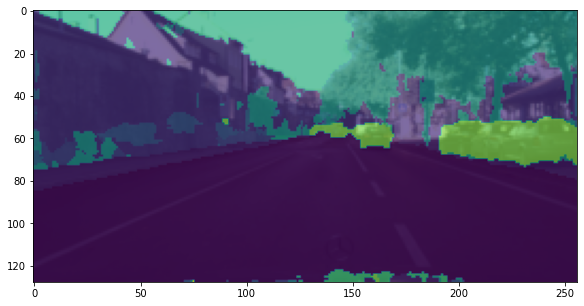

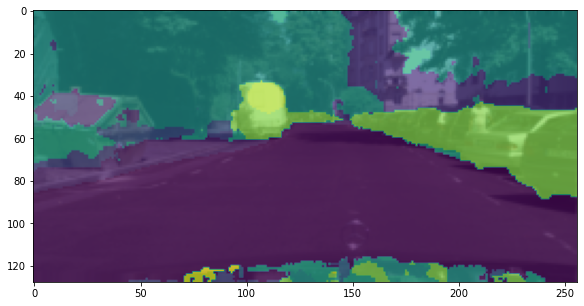

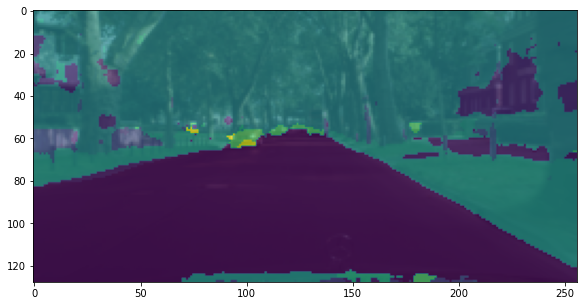

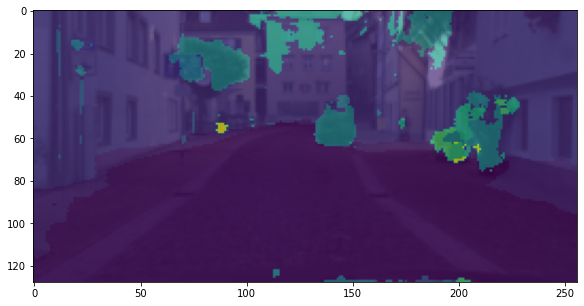

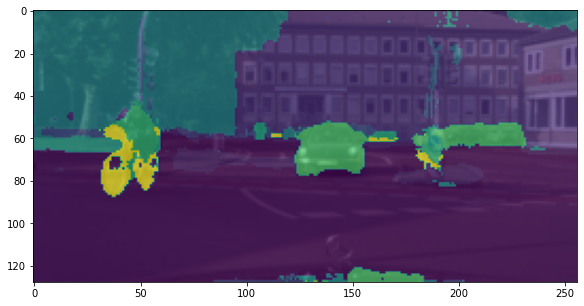

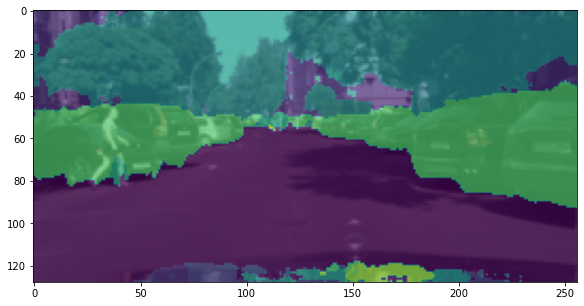

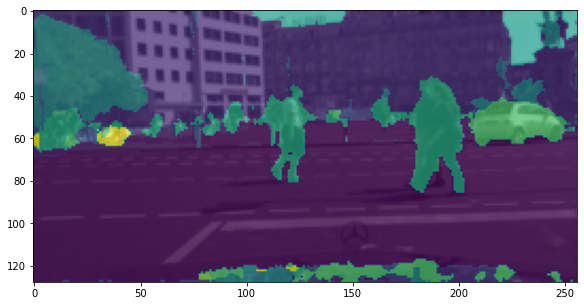

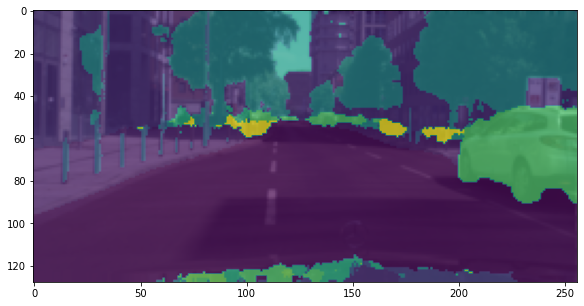

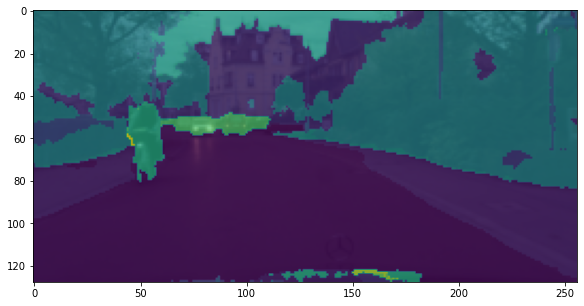

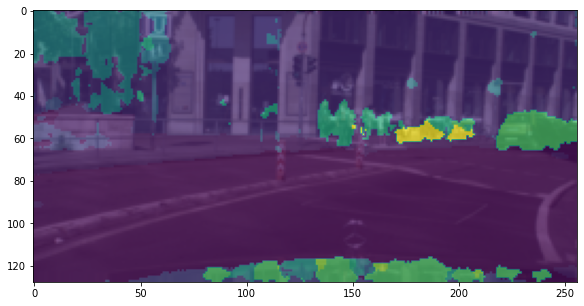

In [34]:
i = 1
for file, seg_pred in zip(files, segmentations):
    img = np.load(VALID_DIR + 'image/' + file)
    
    plt.figure(figsize = (10,5))
    plt.imshow(img)
    plt.imshow(seg_pred, alpha = 0.7)
#     plt.savefig(f"segmentation/seg_overlay_{i}.png")
    i += 1

### Depth Maps

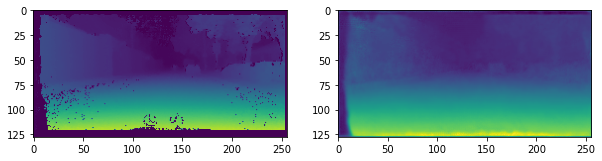

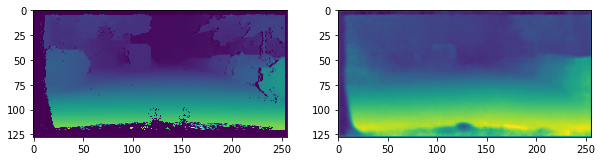

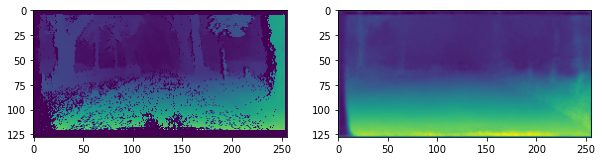

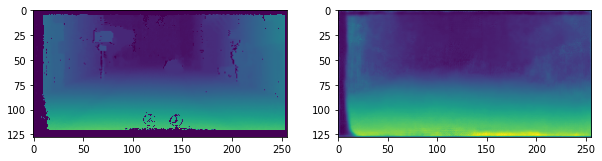

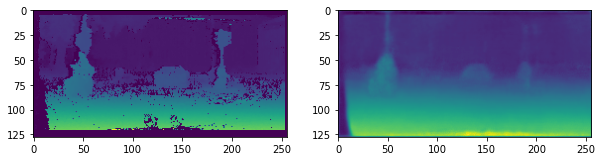

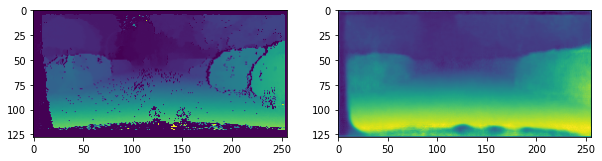

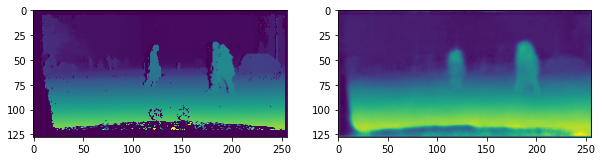

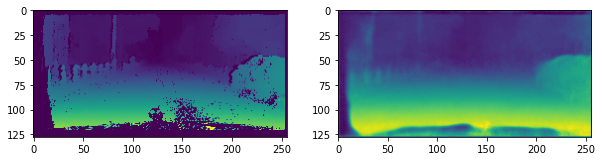

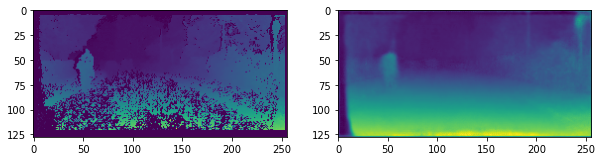

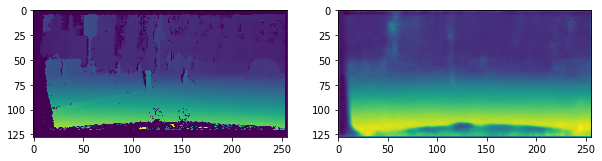

In [35]:
i = 1
for file, depth_pred in zip(files, depths):
    depth_label = np.load(VALID_DIR + 'depth/' + file)
    
    plt.figure(figsize = (10,5))
    plt.subplot(1, 2, 1)
    plt.imshow(depth_label)

    plt.subplot(1, 2, 2)
    plt.imshow(depth_pred)
#     plt.savefig(f"depth_est/depth_demo_{i}.png")
    i += 1

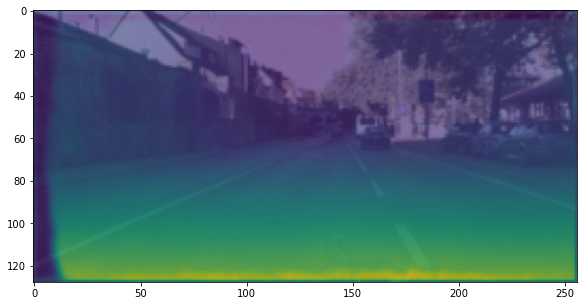

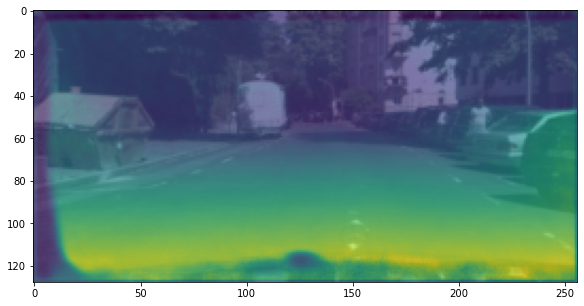

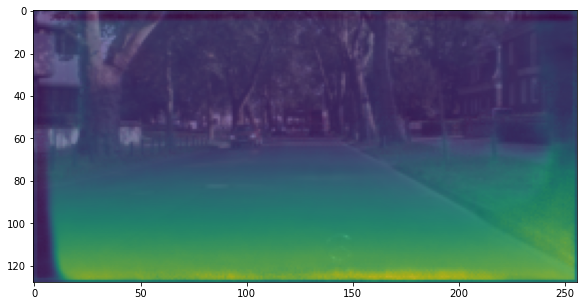

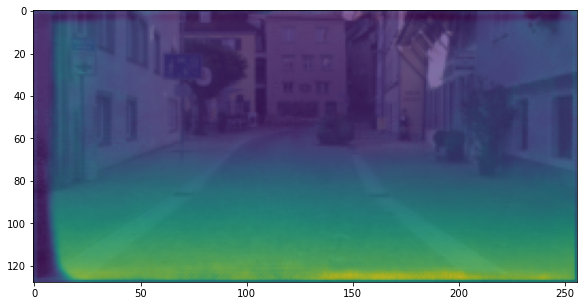

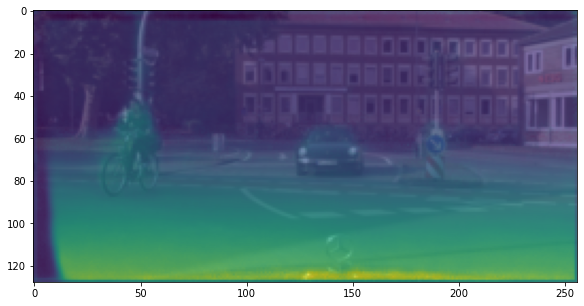

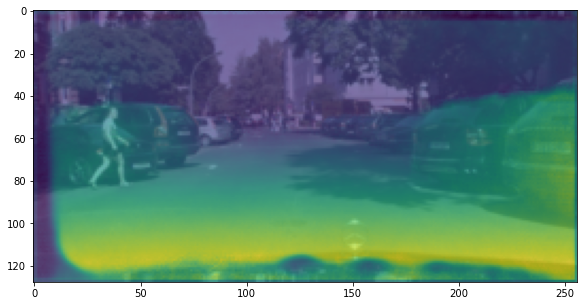

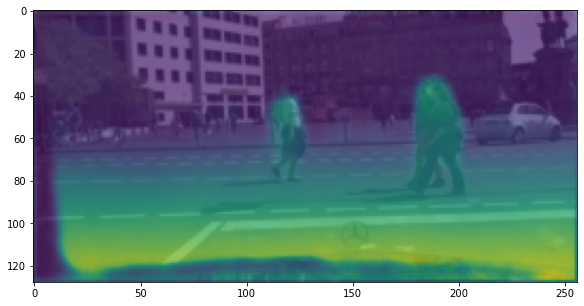

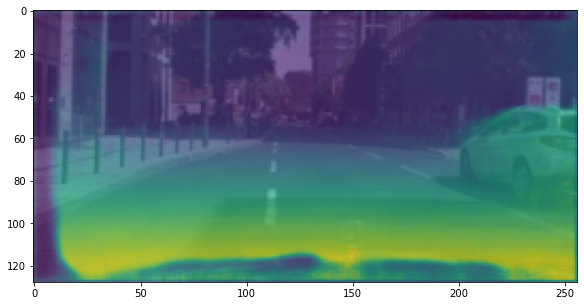

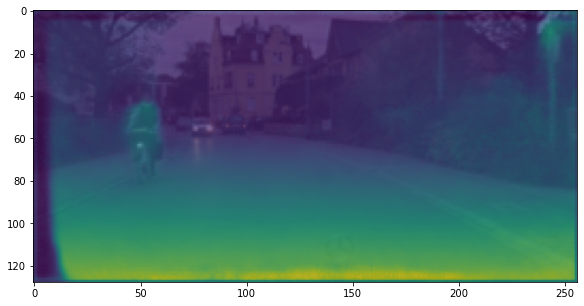

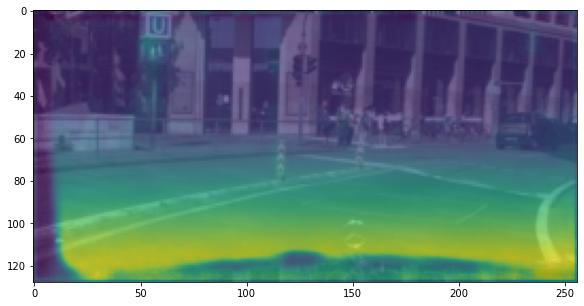

In [36]:
i = 1
for file, depth_pred in zip(files, depths):
    img = np.load(VALID_DIR + 'image/' + file)
    
    plt.figure(figsize = (10,5))
    plt.imshow(img)
    plt.imshow(depth_pred, alpha = 0.7)
#     plt.savefig(f"depth_est/depth_overlay_{i}.png")
    i += 1    